In [ ]:
!pip install torch torchvision numpy tqdm matplotlib plotnine pandas

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/RobustBench/robustbench.git to /scratch/yjabary/apptainer_env/venv/.local/pip-req-build-4r9ui924
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /scratch/yjabary/apptainer_env/venv/.local/pip-req-build-4r9ui924
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /scratch/yjabary/apptainer_env/venv/.local/pip-install-f9xp7vxk/autoattack_cbc2b2df13984972ac1697e68aea04a0
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /scratch/yjabary/apptainer_env/venv/.local/pip-install-f9xp7vxk/autoattack_cbc2b2df13984972ac1697e68aea04a0
  Running command git rev-parse -q --verify 'sha^a39220048b3c9

/scratch/yjabary/apptainer_env/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169M/169M [00:06<00:00, 27.8MB/s]


Extracting /scratch/yjabary/self-ensembling/datasets/cifar-100-python.tar.gz to /scratch/yjabary/self-ensembling/datasets
Files already downloaded and verified


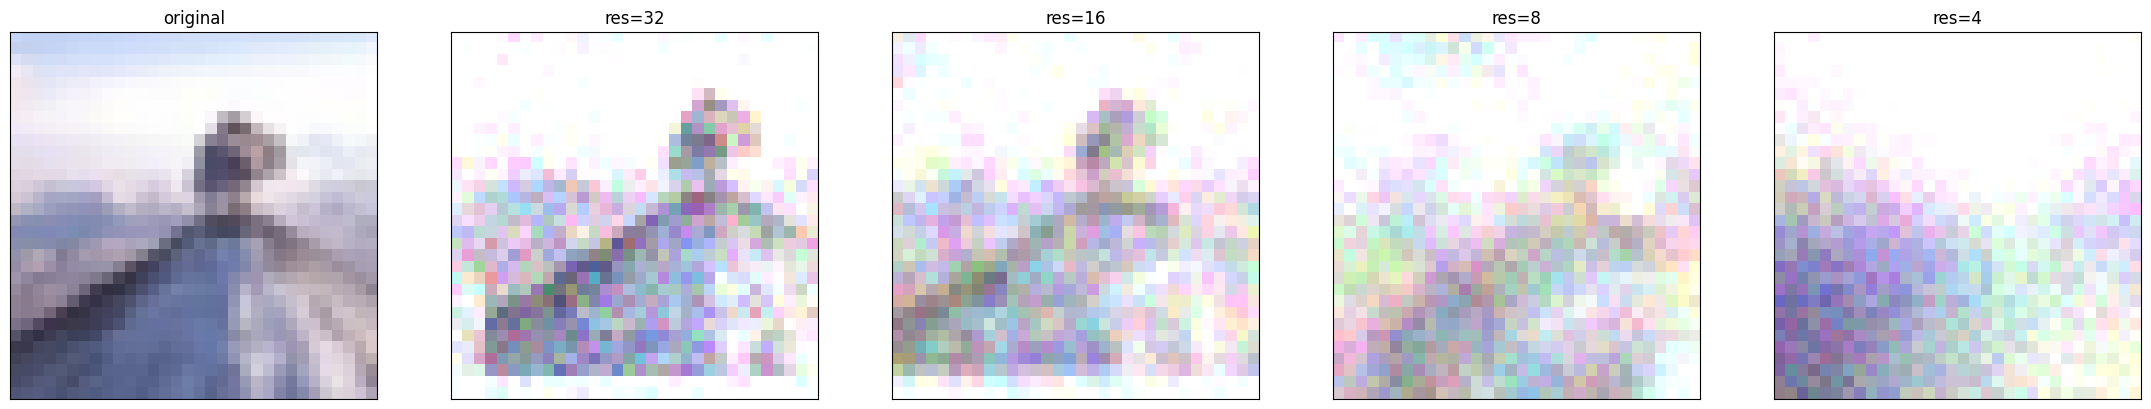

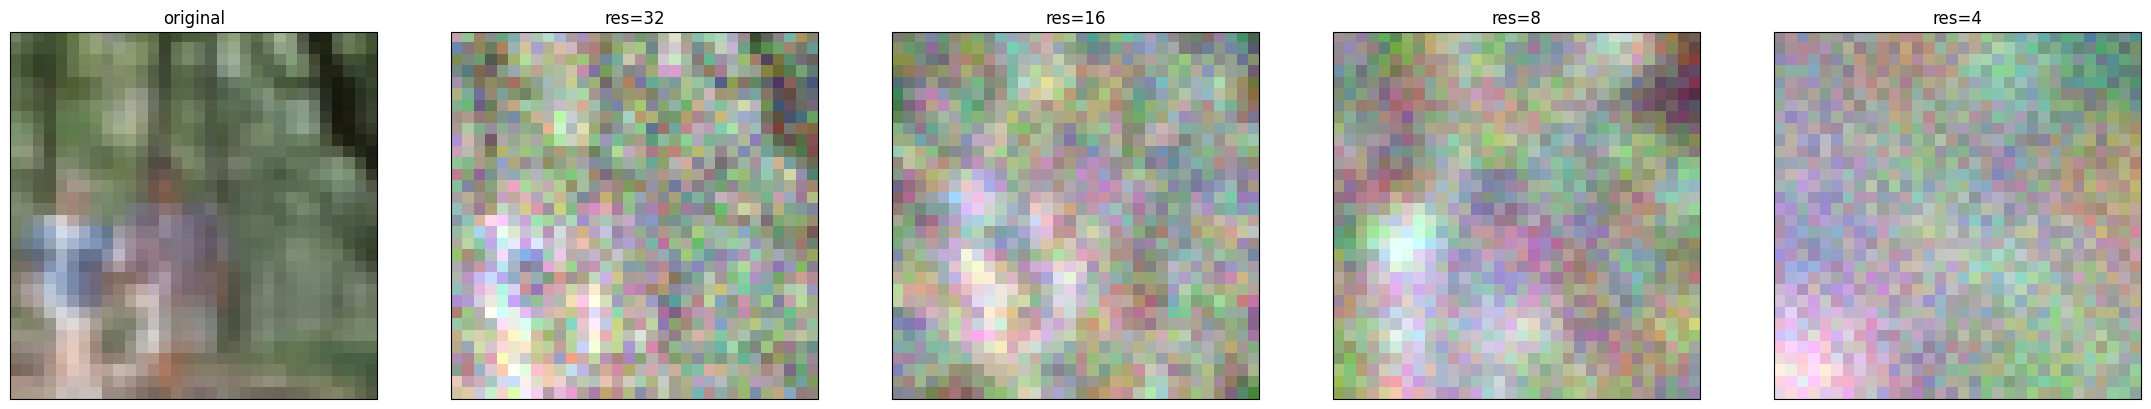

In [ ]:
import copy
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *

assert torch.cuda.is_available()
gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
assert gpu_memory >= 79, "at least 80GB gpu memory required"

set_env()


#
# data
#


data_path = get_current_dir().parent / "data"
dataset_path = get_current_dir().parent / "datasets"
weights_path = get_current_dir().parent / "weights"

os.makedirs(data_path, exist_ok=True)
os.makedirs(dataset_path, exist_ok=True)
os.makedirs(weights_path, exist_ok=True)

dataset = "cifar100"
if dataset == "cifar10":
    num_classes = 10
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=torchvision.transforms.ToTensor())
    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=torchvision.transforms.ToTensor())

    original_images_train_np = np.array(trainset.data)
    original_labels_train_np = np.array(trainset.targets)

    original_images_test_np = np.array(testset.data)
    original_labels_test_np = np.array(testset.targets)

elif dataset == "cifar100":
    num_classes = 100
    trainset = torchvision.datasets.CIFAR100(root=dataset_path, train=True, download=True, transform=torchvision.transforms.ToTensor())
    testset = torchvision.datasets.CIFAR100(root=dataset_path, train=False, download=True, transform=torchvision.transforms.ToTensor())

    original_images_train_np = np.array(trainset.data)
    original_labels_train_np = np.array(trainset.targets)

    original_images_test_np = np.array(testset.data)
    original_labels_test_np = np.array(testset.targets)

elif dataset == "imagenette":
    num_classes = 10
    trainset = torchvision.datasets.Imagenette(root=dataset_path, split="train", download=True, transform=torchvision.transforms.ToTensor())
    testset = torchvision.datasets.Imagenette(root=dataset_path, split="val", download=True, transform=torchvision.transforms.ToTensor())

    original_images_train_np = []
    original_labels_train_np = []
    for image, label in trainset:
        original_images_train_np.append(np.transpose(image.numpy(), (1, 2, 0)) * 255)
        original_labels_train_np.append(label)

    original_images_test_np = []
    original_labels_test_np = []
    for image, label in testset:
        original_images_test_np.append(np.transpose(image.numpy(), (1, 2, 0)) * 255)
        original_labels_test_np.append(label)

    original_images_train_np = np.array(original_images_train_np, dtype=np.uint8)
    original_labels_train_np = np.array(original_labels_train_np)
    original_images_test_np = np.array(original_images_test_np, dtype=np.uint8)
    original_labels_test_np = np.array(original_labels_test_np)
else:
    assert False

# images between 0 and 1 instead of 0 and 255
images_train_np = original_images_train_np / 255.0
images_test_np = original_images_test_np / 255.0

labels_train_np = original_labels_train_np
labels_test_np = original_labels_test_np


#
# preprocessing
#


skip_preprocessing = False  # just stack, don't do anything else

resolutions = [32, 16, 8, 4]  # pretty arbitrary
down_noise = 0.2  # noise standard deviation to be added at the low resolution
up_noise = 0.2  # noise stadard deviation to be added at the high resolution
jit_size = 3  # max size of the x-y jit in each axis, sampled uniformly from -jit_size to +jit_size inclusive
up_res = 32  # hard coded for CIFAR-10 or CIFAR-100
shuffle_image_versions_randomly = False  # to shuffle randomly which image is which in the multi-res stack (false in paper)


def make_multichannel_input(images):
    if skip_preprocessing:
        return torch.concatenate([images] * len(resolutions), axis=1)  # don't do anything

    all_channels = []
    for i, r in enumerate(resolutions):

        def apply_transformations(images, down_res, up_res, jit_x, jit_y, down_noise, up_noise, contrast, color_amount):
            # images = torch.mean(images,axis=1,keepdims=True) # only for mnist
            images_collected = []
            for i in range(images.shape[0]):
                image = images[i]
                image = torchvision.transforms.functional.adjust_contrast(image, contrast[i])  # changing contrast
                image = torch.roll(image, shifts=(jit_x[i], jit_y[i]), dims=(-2, -1))  # shift the result in x and y
                image = color_amount[i] * image + torch.mean(image, axis=0, keepdims=True) * (1 - color_amount[i])  # shifting in the color <-> grayscale axis
                images_collected.append(image)
            images = torch.stack(images_collected, axis=0)
            images = F.interpolate(images, size=(down_res, down_res), mode="bicubic")  # descrease the resolution
            noise = down_noise * torch.Tensor(np.random.rand(images.shape[0], 3, down_res, down_res)).to("cuda")  # low res noise
            images = images + noise
            images = F.interpolate(images, size=(up_res, up_res), mode="bicubic")  # increase the resolution
            noise = up_noise * torch.Tensor(np.random.rand(images.shape[0], 3, up_res, up_res)).to("cuda")  # high res noise
            images = images + noise
            images = torch.clip(images, 0, 1)  # clipping to the right range of values
            return images

        images_now = apply_transformations(
            images,
            down_res=r,
            up_res=up_res,
            jit_x=np.random.choice(range(-jit_size, jit_size + 1), len(images + i)),  # x-shift,
            jit_y=np.random.choice(range(-jit_size, jit_size + 1), len(51 * images + 7 * i + 125 * r)),  # y-shift
            down_noise=down_noise,
            up_noise=up_noise,
            contrast=np.random.choice(np.linspace(0.7, 1.5, 100), len(7 + 3 * images + 9 * i + 5 * r)),  # change in contrast,
            color_amount=np.random.choice(np.linspace(0.5, 1.0, 100), len(5 + 7 * images + 8 * i + 2 * r)),  # change in color amount
        )
        all_channels.append(images_now)

    if not shuffle_image_versions_randomly:
        return torch.concatenate(all_channels, axis=1)
    elif shuffle_image_versions_randomly:
        indices = torch.randperm(len(all_channels))
        shuffled_tensor_list = [all_channels[i] for i in indices]
        return torch.concatenate(shuffled_tensor_list, axis=1)


plot = True
if plot:
    sample_images = images_test_np[:5]
    for j in [0, 1]:
        multichannel_images = make_multichannel_input(torch.Tensor(sample_images.transpose([0, 3, 1, 2])).to("cuda")).detach().cpu().numpy().transpose([0, 2, 3, 1])
        N = 1 + multichannel_images.shape[3] // 3
        plt.figure(figsize=(N * 5.5, 5))
        plt.subplot(1, N, 1)
        plt.title("original")
        plt.imshow(sample_images[j])
        plt.xticks([], [])
        plt.yticks([], [])
        for i in range(N - 1):
            plt.subplot(1, N, i + 2)
            plt.title(f"res={resolutions[i]}")
            plt.imshow(multichannel_images[j, :, :, 3 * i : 3 * (i + 1)])
            plt.xticks([], [])
            plt.yticks([], [])
        plt.show()

In [ ]:
#
# train and eval loop
#


@timeit
def eval_model(model, images_in, labels_in, batch_size=128):
    all_preds = []
    all_logits = []

    with torch.no_grad():
        its = int(np.ceil(float(len(images_in)) / float(batch_size)))
        pbar = tqdm(range(its), desc="eval", ncols=100)
        for it in pbar:
            i1 = it * batch_size
            i2 = min([(it + 1) * batch_size, len(images_in)])

            inputs = torch.Tensor(images_in[i1:i2].transpose([0, 3, 1, 2])).to("cuda")
            outputs = model(inputs)

            all_logits.append(outputs.detach().cpu().numpy())
            preds = torch.argmax(outputs, axis=-1)
            all_preds.append(preds.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_logits = np.concatenate(all_logits, axis=0)
    return np.sum(all_preds == labels_in), all_preds.shape[0], all_logits


def fgsm_attack(model, xs, ys, epsilon, random_reps, batch_size):
    model = model.eval()

    all_perturbed_images = []

    its = int(np.ceil(xs.shape[0] / batch_size))
    for it in range(its):
        i1 = it * batch_size
        i2 = min([(it + 1) * batch_size, xs.shape[0]])

        x = torch.Tensor(xs[i1:i2].transpose([0, 3, 1, 2])).to("cuda")
        y = torch.Tensor(ys[i1:i2]).to("cuda").to(torch.long)
        x.requires_grad = True

        for _ in range(random_reps):
            outputs = model(x)
            loss = nn.CrossEntropyLoss()(outputs, y)
            loss.backward()

        perturbed_image = x + epsilon * x.grad.data.sign()
        perturbed_image = torch.clip(perturbed_image, 0, 1)
        all_perturbed_images.append(perturbed_image.detach().cpu().numpy().transpose([0, 2, 3, 1]))
    return np.concatenate(all_perturbed_images, axis=0)


@timeit
def train_model(model_in, images_in, labels_in, epochs, lr, batch_size, optimizer_in, subset_only, mode, use_adversarial_training, adversarial_epsilon, skip_test_set_eval):
    global storing_models

    if mode == "train":
        model_in.train()
    elif mode == "eval":
        model_in.eval()

    criterion = nn.CrossEntropyLoss()

    if subset_only is None:
        train_optimizer = optimizer_in(model_in.parameters(), lr=lr)
    else:
        train_optimizer = optimizer_in(subset_only, lr=lr)

    for epoch in range(epochs):
        if mode == "train":  # avoid random flips
            model_in.train()
        elif mode == "eval":
            model_in.eval()
        else:
            assert False

        all_hits = []

        randomized_ids = np.random.permutation(range(len(images_in)))
        its = int(np.ceil(float(len(images_in)) / float(batch_size)))
        pbar = tqdm(range(its), desc="Training", ncols=100)
        for it in pbar:
            i1 = it * batch_size
            i2 = min([(it + 1) * batch_size, len(images_in)])

            np_images_used = images_in[randomized_ids[i1:i2]]
            np_labels_used = labels_in[randomized_ids[i1:i2]]

            if use_adversarial_training:  # very light adversarial training if on
                attacked_images = fgsm_attack(model_in.eval(), np_images_used[:], np_labels_used[:], epsilon=adversarial_epsilon, random_reps=1, batch_size=batch_size // 2)
                np_images_used = attacked_images
                np_labels_used = np_labels_used
                if mode == "train":
                    model_in.train()
                elif mode == "eval":
                    model_in.eval()

            inputs = torch.Tensor(np_images_used.transpose([0, 3, 1, 2])).to("cuda")
            labels = torch.Tensor(np_labels_used).to("cuda").to(torch.long)

            # the actual optimization step
            train_optimizer.zero_grad()
            outputs = model_in(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            train_optimizer.step()

            # on the fly eval for the train set batches
            preds = torch.argmax(outputs, axis=-1)
            acc = torch.mean((preds == labels).to(torch.float), axis=-1)
            all_hits.append((preds == labels).to(torch.float).detach().cpu().numpy())
            train_accs.append(acc.detach().cpu().numpy())

            pbar.set_description(f"train acc={acc.detach().cpu().numpy()} loss={loss.item()}")

        if not skip_test_set_eval:
            with isolated_environment():
                eval_model_copy = copy.deepcopy(model_in)
                test_hits, test_count, _ = eval_model(eval_model_copy.eval(), images_test_np, labels_test_np)

        # end of epoch eval
        train_hits = np.sum(np.concatenate(all_hits, axis=0).reshape([-1]))
        train_count = np.concatenate(all_hits, axis=0).reshape([-1]).shape[0]
        print(f"e={epoch} train {train_hits} / {train_count} = {train_hits/train_count},  test {test_hits} / {test_count} = {test_hits/test_count}")

        test_accs.append((test_hits / test_count) if (test_count > 0) else 0)

    print("done")
    return model_in


#
# training backbone
#


from torchvision.models import resnet152, ResNet152_Weights

imported_model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# replace first conv layer with multi-res one
in_planes = 3
planes = 64
stride = 2
N = len(resolutions)  # input channels multiplier due to multi-res input
conv2 = nn.Conv2d(in_channels=N * in_planes, out_channels=planes, kernel_size=7, stride=stride, padding=3, bias=False)
imported_model.conv1 = copy.deepcopy(conv2)

# set num of classes in final layer
imported_model.fc = nn.Linear(2048, num_classes)


class ImportedModelWrapper(nn.Module):
    def __init__(self, imported_model, multichannel_fn):
        super(ImportedModelWrapper, self).__init__()
        self.imported_model = imported_model
        self.multichannel_fn = multichannel_fn

    def forward(self, x):
        # multichannel input
        x = self.multichannel_fn(x)
        # imagenet preprocessing
        x = F.interpolate(x, size=(224, 224), mode="bicubic")
        x = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406] * (x.shape[1] // 3), std=[0.229, 0.224, 0.225] * (x.shape[1] // 3))(x)
        x = self.imported_model(x)
        return x


wrapped_model = ImportedModelWrapper(imported_model, make_multichannel_input).to("cuda")
wrapped_model.multichannel_fn = make_multichannel_input
model = copy.deepcopy(wrapped_model)
model.multichannel_fn = make_multichannel_input
model.train()

train_accs = []
test_accs = []

torch.cuda.empty_cache()
# with torch.autocast("cuda"):
model = train_model(
    model_in=model,
    images_in=images_train_np,
    labels_in=labels_train_np,
    epochs=6,
    lr=3.3e-5,  # simple grid search, likely not optimal
    batch_size=128,
    optimizer_in=optim.Adam,
    subset_only=None,
    mode="train",
    use_adversarial_training=False,
    adversarial_epsilon=8 / 255,
    skip_test_set_eval=False,
)


#
# training self ensemble layers
#


class WrapModelForResNet152(torch.nn.Module):
    def __init__(self, model, multichannel_fn, num_classes=10):
        super(WrapModelForResNet152, self).__init__()
        self.multichannel_fn = multichannel_fn
        self.model = model
        self.num_classes = num_classes
        self.layer_operations = [
            torch.nn.Sequential(
                model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
            ),
            *model.layer1,
            *model.layer2,
            *model.layer3,
            *model.layer4,
            model.avgpool,
            model.fc,
        ]
        self.all_dims = [
            3 * 224 * 224 * len(resolutions),
            64 * 56 * 56,
            *[256 * 56 * 56] * len(model.layer1),
            *[512 * 28 * 28] * len(model.layer2),
            *[1024 * 14 * 14] * len(model.layer3),
            *[2048 * 7 * 7] * len(model.layer4),
            2048,
            1000,
        ]

        class BatchNormLinear(nn.Module):
            def __init__(self, in_features, out_features, device="cuda"):
                super(BatchNormLinear, self).__init__()
                self.batch_norm = nn.BatchNorm1d(in_features, device=device)
                self.linear = nn.Linear(in_features, out_features, device=device)

            def forward(self, x):
                x = self.batch_norm(x)
                return self.linear(x)

        self.linear_layers = torch.nn.ModuleList([BatchNormLinear(self.all_dims[i], num_classes, device="cuda") for i in range(len(self.all_dims))])

    def prepare_input(self, x):  # preprocess
        x = self.multichannel_fn(x)
        x = F.interpolate(x, size=(224, 224), mode="bicubic")
        x = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406] * (x.shape[1] // 3), std=[0.229, 0.224, 0.225] * (x.shape[1] // 3))(x)
        return x

    def forward_until(self, x, layer_id):
        x = self.prepare_input(x)
        for l in range(layer_id):  # forward until layer_id
            if list(x.shape)[1:] == [2048, 1, 1]:
                x = x.reshape([-1, 2048])
            x = self.layer_operations[l](x)
        return x

    def forward_after(self, x, layer_id):
        x = self.prepare_input(x)
        for l in range(layer_id, len(self.layer_operations)):  # forward from layer_id
            if list(x.shape)[1:] == [2048, 1, 1]:
                x = x.reshape([-1, 2048])
            x = self.layer_operations[l](x)
        return x

    def predict_from_layer(self, x, l):
        x = self.forward_until(x, l)
        x = x.reshape([x.shape[0], -1])
        return self.linear_layers[l](x)

    def predict_from_several_layers(self, x, layers):
        x = self.prepare_input(x)
        outputs = dict()
        outputs[0] = self.linear_layers[0](x.reshape([x.shape[0], -1]))
        for l in range(len(self.layer_operations)):
            if list(x.shape)[1:] == [2048, 1, 1]:
                x = x.reshape([-1, 2048])
            x = self.layer_operations[l](x)
            if l in layers:
                outputs[l + 1] = self.linear_layers[l + 1](x.reshape([x.shape[0], -1]))
        return outputs


class LinearNet(nn.Module):
    def __init__(self, model, layer_i):
        super(LinearNet, self).__init__()
        self.model = model
        self.layer_i = layer_i

    def forward(self, inputs):
        return self.model.predict_from_layer(inputs, self.layer_i)


resnet152_wrapper = WrapModelForResNet152(model.imported_model, make_multichannel_input, num_classes=num_classes)
resnet152_wrapper.multichannel_fn = make_multichannel_input
resnet152_wrapper = resnet152_wrapper.to("cuda")
assert all([resnet152_wrapper.predict_from_layer(torch.Tensor(np.zeros((2, 3, 32, 32))).cuda(), layer_i).shape == torch.Size([2, 100]) for layer_i in range(53)])
backbone_model = copy.deepcopy(resnet152_wrapper)
del resnet152_wrapper

backbone_model.eval()
linear_model = LinearNet(backbone_model, 5).to("cuda")  # just to have it ready

layers_to_use = [20, 30, 35, 40, 45, 50, 52]  # only some layers to save time
linear_layers_collected_dict = dict()

for layer_i in reversed(layers_to_use):
    print(f"training layer={layer_i}")
    linear_model.layer_i = layer_i
    linear_model.fixed_mode = "train"

    train_accs = []
    test_accs = []
    robust_accs = []
    clean_accs = []
    actual_robust_accs = []

    torch.cuda.empty_cache()
    linear_model = train_model(
        model_in=linear_model,
        images_in=images_train_np[:],
        labels_in=labels_train_np[:],
        epochs=1,
        lr=3.3e-5,
        batch_size=64,
        optimizer_in=optim.Adam,
        subset_only=linear_model.model.linear_layers[layer_i].parameters(),  # just the linear projection
        mode="train",
        use_adversarial_training=False,
        adversarial_epsilon=8 / 255,
        skip_test_set_eval=False,
    )
    linear_layers_collected_dict[layer_i] = copy.deepcopy(backbone_model.linear_layers[layer_i])

 # copy dict back to backbone
for layer_i in layers_to_use:
    backbone_model.linear_layers[layer_i] = copy.deepcopy(linear_layers_collected_dict[layer_i])
del linear_layers_collected_dict

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /scratch/yjabary/apptainer_env/torch_cache/hub/checkpoints/resnet152-f82ba261.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230M/230M [00:00<00:00, 315MB/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.60it/s]


e=0 train 3100.0 / 50000 = 0.06199999898672104,  test 1408 / 10000 = 0.1408


train acc=0.2750000059604645 loss=2.799875259399414: 100%|████████| 391/391 [02:51<00:00,  2.27it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.56it/s]


e=1 train 11325.0 / 50000 = 0.226500004529953,  test 3157 / 10000 = 0.3157


train acc=0.4000000059604645 loss=2.1474509239196777: 100%|███████| 391/391 [02:51<00:00,  2.29it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.85it/s]


e=2 train 19513.0 / 50000 = 0.3902600109577179,  test 4467 / 10000 = 0.4467


train acc=0.612500011920929 loss=1.7065765857696533: 100%|████████| 391/391 [02:51<00:00,  2.28it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.29it/s]


e=3 train 24799.0 / 50000 = 0.49597999453544617,  test 5103 / 10000 = 0.5103


train acc=0.5875000357627869 loss=1.5127522945404053: 100%|███████| 391/391 [02:51<00:00,  2.28it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.09it/s]


e=4 train 28234.0 / 50000 = 0.5646799802780151,  test 5613 / 10000 = 0.5613


train acc=0.675000011920929 loss=1.0542172193527222: 100%|████████| 391/391 [02:52<00:00,  2.27it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.68it/s]

e=5 train 30811.0 / 50000 = 0.6162199974060059,  test 5889 / 10000 = 0.5889

Finished Training


In [ ]:
#
# final test eval
# 


def eval_layer(model, images_in, labels_in, batch_size=128):
    all_preds = []
    all_logits = []

    with torch.no_grad():
        its = int(np.ceil(float(len(images_in)) / float(batch_size)))
        pbar = tqdm(range(its), desc="eval", ncols=100)
        for it in pbar:
            i1 = it * batch_size
            i2 = min([(it + 1) * batch_size, len(images_in)])

            inputs = torch.Tensor(images_in[i1:i2].transpose([0, 3, 1, 2])).to("cuda")
            outputs = model(inputs)

            all_logits.append(outputs.detach().cpu().numpy())
            preds = torch.argmax(outputs, axis=-1)
            all_preds.append(preds.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_logits = np.concatenate(all_logits, axis=0)
    return np.sum(all_preds == labels_in), all_preds.shape[0], all_logits


def eval_self_ensemble(backbone_model, images_test, labels_test, layers_to_use, batch_size=128):
    backbone_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i in range(0, len(images_test), batch_size):
            batch_images = torch.Tensor(images_test[i:i+batch_size]).cuda()
            batch_labels = labels_test[i:i+batch_size]
            
            # get predictions from all layers
            layer_outputs = []
            for layer_i in layers_to_use:
                outputs = backbone_model.predict_from_layer(batch_images, layer_i)
                layer_outputs.append(outputs.unsqueeze(1))
            
            # stack predictions from all layers
            ensemble_outputs = torch.cat(layer_outputs, dim=1)  # [batch_size, num_layers, num_classes]
            
            def get_cross_max_consensus(outputs: torch.Tensor, k: int, self_assemble_mode: bool = False) -> torch.Tensor:
                # outputs shape: [batch_size, ensemble_size, num_classes]
                Z_hat = outputs - outputs.max(dim=2, keepdim=True)[0]  # subtract the max per-predictor over classes
                Z_hat = Z_hat - Z_hat.max(dim=1, keepdim=True)[0]  # subtract the per-class max over predictors
                Y, _ = torch.topk(Z_hat, k, dim=1)  # get highest k values per class
                if self_assemble_mode:
                    Y = torch.median(Z_hat, dim=1)[0]  # get median value per class
                else:
                    Y = Y[:, -1, :]  # get the k-th highest value per class
                _, predicted = torch.max(Y, 1)  # get the index of the maximum value
                assert predicted.shape == (outputs.shape[0],)  # assert [batch_size]
                assert len(predicted.shape) == 1
                assert (predicted >= 0).all() and (predicted < outputs.shape[2]).all()  # assert [0, num_classes)
                assert predicted.dtype == torch.int64  # assert integer
                return predicted

            predictions = get_cross_max_consensus(ensemble_outputs, k=3, self_assemble_mode=True)

            all_preds.append(predictions.cpu().numpy())
            all_labels.append(batch_labels)
            
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    accuracy = np.mean(all_preds == all_labels)
    return accuracy


backbone_model.cuda()
backbone_model.eval()

layer_acc = []
for layer_i in layers_to_use:
    linear_model = LinearNet(backbone_model, layer_i).to("cuda")
    linear_model.eval()
    test_hits, test_count, _ = eval_layer(linear_model, images_test_np, labels_test_np)
    layer_acc.append(test_hits / test_count)

ensemble_acc = eval_self_ensemble(backbone_model, images_test_np, labels_test_np, layers_to_use)

# plt.figure(figsize=(7, 5), dpi=100)
# plt.title("accuracy at intermediate layers", fontsize=14)
# plt.plot(layers_to_use, layer_acc, marker="o", color="navy", label="Test")
# plt.legend(fontsize=16)
# plt.xlabel("layer", fontsize=14)
# plt.ylabel("accuracy", fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

df = pd.DataFrame({'layer': layers_to_use, 'accuracy': layer_acc, 'type': ['Test'] * len(layers_to_use)})
(ggplot(df, aes(x='layer', y='accuracy', color='type', group='type')) + geom_line() + labs(title='Accuracy at Intermediate Layers', x='Layer', y='Accuracy')).show()

print("layer,test_acc")
for layer_i, acc in zip(layers_to_use, layer_acc):
    print(f"{layer_i},{acc}")

print(f"ensemble:{ensemble_acc}")